In [1]:
from jaxNRSur.SurrogateModel import NRSur7dq4Model
import jax.numpy as jnp
import numpy as np
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

q = 2
incl = 1.4376
phiref = 2.65

chi1 = jnp.array([-0.19, 0, 0.3])
chi2 = jnp.array([0.01, 0, 0.8])

params = jnp.array([q, chi1[0], chi1[1], chi1[2], chi2[0], chi2[1], chi2[2]])

model = NRSur7dq4Model()
waveform_jax, dyn_jax = model.get_waveform(jnp.linspace(0, 1, 10), params, theta=incl, phi=phiref) # note the time array here doesn't do anything 

import gwsurrogate

gwsurrogate.catalog.pull('NRSur7dq4')
sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

#t, h, dyn = sur(q, np.array([0,0,0]), np.array([0,0,0]), dt=1, f_low=0, inclination=incl, phi_ref=jnp.pi/2, units='dimensionless', precessing_opts={'return_dynamics': True})
t, h, dyn = sur(q, chi1, chi2, dt=1, f_low=0, units='dimensionless', precessing_opts={'return_dynamics': True})

orbphase_gwsur = interp1d(t, dyn['orbphase'][:,], bounds_error=False, fill_value=0)(model.data.t_coorb)

/workspaces/JaxNRSur/src/jaxNRSur/PolyPredictor.py:29: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite typechecker: usually one of the two lines below.
from typeguard import typechecked as typechecker
from beartype import beartype as typechecker

@jaxtyped(typechecker=typechecker)
def foo(...):
```
and the old double-decorator syntax
```
@jaxtyped
@typechecker
def foo(...):
```
should no longer be used. (It will continue to work as it did before, but the new approach will produce more readable error messages.)
In particular note that `typechecker` must be passed via keyword argument; the following is not valid:
```
@jaxtyped(typechecker)
def foo(...):
```

  def predict(


Try loading file from cache
Cache found and loading data
cannot import LAL
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new

NRSur7dq4.h5 file exits, moving to /home/codespace/.python/current/lib/python3.10/site-packages/gwsurrogate/surrogate_downloads/backup/2024Oct22_21h:02m:19s_NRSur7dq4.h5.
There are a lot of backup files in /home/codespace/.python/current/lib/python3.10/site-packages/gwsurrogate/surrogate_downloads/backup, consider removing some.
Loaded NRSur7dq4 model


In [2]:
from jaxNRSur.Harmonics import SpinWeightedSphericalHarmonics
from gwtools.harmonics import sYlm as _sYlm


for idx, mode in enumerate(list(model.modelist_dict_extended.keys())):

    print(mode, SpinWeightedSphericalHarmonics(-2, mode[0], mode[1])(incl, phiref), _sYlm(-2, mode[0], mode[1], incl,phiref))

(2, 0) (0.3794616415656599+0j) (0.3794616415656599+0j)
(2, 1) (-0.31217872277830944+0.16715161919238025j) (-0.31217872277830944+0.16715161919238025j)
(2, -1) (-0.23898289912322399-0.12795996534364604j) (-0.23898289912322399-0.12795996534364604j)
(2, 2) (0.11218423925972859-0.16841921382946984j) (0.11218423925972859-0.16841921382946984j)
(2, -2) (0.06574442008910432+0.09870034880252698j) (0.06574442008910432+0.09870034880252698j)
(3, 0) (0.13332888089996064+0j) (0.13332888089996064+0j)
(3, 1) (0.17567461995986222-0.09406245536519083j) (0.17567461995986222-0.09406245536519083j)
(3, -1) (-0.31261146708988874-0.16738332592669264j) (-0.31261146708988874-0.16738332592669264j)
(3, 2) (-0.21259234495519558+0.31915923163344473j) (-0.21259234495519558+0.31915923163344473j)
(3, -2) (0.18657182946319925+0.28009532398012854j) (0.18657182946319925+0.28009532398012854j)
(3, 3) (0.027865140709553482-0.28931395846883057j) (0.027865140709553482-0.28931395846883057j)
(3, -3) (-0.016330079240538396-0.1695

In [3]:
orbphase_gwsur = interp1d(t, dyn['orbphase'][:,], bounds_error=False, fill_value=0, kind='cubic')(model.data.t_coorb)
quat_gwsur = interp1d(t, dyn['q_copr'][:,], bounds_error=False, fill_value=0, kind='cubic')(model.data.t_coorb)
chi1_gwsur = interp1d(t, dyn['chiA_copr'][:,].T, bounds_error=False, fill_value=0, kind='cubic')(model.data.t_coorb)
chi2_gwsur = interp1d(t, dyn['chiB_copr'][:,].T, bounds_error=False, fill_value=0, kind='cubic')(model.data.t_coorb)

In [4]:
Omega_interp_gwsur = jnp.hstack([quat_gwsur.T, orbphase_gwsur[:,jnp.newaxis], chi1_gwsur.T, chi2_gwsur.T])

In [5]:
# plt.plot(t, h, label='gwsur')
# plt.plot(model.data.t_coorb, waveform_jax, label='Jax')

# plt.xlabel('time [M]')
# plt.legend(loc='upper left')

# plt.xlim(-200,50)

# plt.show()

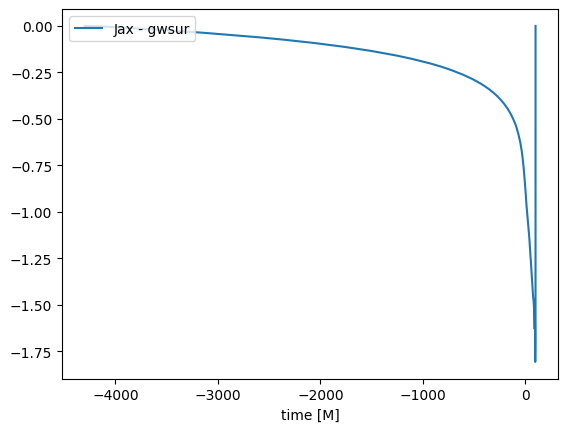

In [6]:
plt.plot(model.data.t_coorb, dyn_jax[:,4]-orbphase_gwsur, label='Jax - gwsur')

plt.xlabel('time [M]')
plt.legend(loc='upper left')

plt.show()

In [12]:
import jax
from gwtools.harmonics import sYlm as _sYlm

coorb_params = jax.vmap(model._get_coorb_params, in_axes=(None, 0))(q, Omega_interp_gwsur)

# Get the lambda parameters to go into the waveform calculation
lambdas = jax.vmap(model._get_fit_params)(
    jax.vmap(model._get_coorb_params, in_axes=(None, 0))(q, Omega_interp_gwsur)
)

# TODO need to work out how to vmap this later
inertial_h_lms = jnp.zeros((len(model.data.t_coorb), model.n_modes_extended), dtype=complex)

inertial_h_lm_array = {}
coorb_h_lm_array = {}


for mode in model.modelist_dict.keys():
    # get the coorb hlms
    coorb_h_lm_plus, coorb_h_lm_minus = model.get_coorb_hlm(lambdas, mode=mode)

    coorb_h_lm_array[mode] = coorb_h_lm_plus
    if mode[1] > 0:
        coorb_h_lm_array[(mode[0], -mode[1])] = coorb_h_lm_minus
    
    # Multiply copressing mode by Wigner-D components (N_modes x times)
    # Note that this also does the rotation of the quaternions into the inertial frame

    inertial_h_lms += (model.wigner_d_coefficients(Omega_interp_gwsur[:,:4], Omega_interp_gwsur[:,4], mode).T * coorb_h_lm_plus).T
    inertial_h_lms += (model.wigner_d_coefficients(Omega_interp_gwsur[:,:4], Omega_interp_gwsur[:,4], (mode[0], -mode[1])).T * coorb_h_lm_minus).T

# Sum along the N_modes axis with the spherical harmonics to generate strain as function of time
inertial_h = jnp.zeros(len(model.data.t_coorb), dtype=complex)
for idx in model.modelist_dict_extended.values():

    mode = list(model.modelist_dict_extended.keys())[idx]
    #inertial_h += _sYlm(-2, mode[0], mode[1], incl,phiref) * inertial_h_lms[:,idx]
    inertial_h += model.harmonics[idx](incl, jnp.pi/2 - phiref) * inertial_h_lms[:,idx]

    inertial_h_lm_array[list(model.modelist_dict_extended.keys())[idx]] = inertial_h_lms[:,idx]

3 (2, 2)


/home/codespace/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/codespace/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


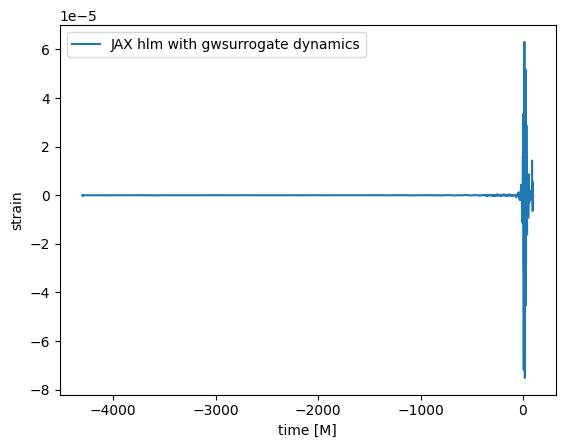

<Figure size 640x480 with 0 Axes>

In [13]:
for mode, i in model.modelist_dict_extended.items():
    if mode[0] < 2:
        print(i, mode)

        print(mode, model.harmonics[i](incl, phiref), _sYlm(-2, mode[0], mode[1], incl,phiref))

        # plt.plot(model.data.t_coorb, interp1d(t,h[mode], bounds_error=False, fill_value=0, kind='cubic')(model.data.t_coorb), label='gwsurrogate')
        # plt.plot(model.data.t_coorb, inertial_h_lm_array[mode], label='JAX with gwsurrogate dynamics')
        # #plt.plot(model.data.t_coorb, interp1d(t,h[mode], bounds_error=False, fill_value=0, kind='linear')(model.data.t_coorb) - inertial_h_lm_array[mode], label='JAX hlm with gwsurrogate dynamics') #(-2.22919481+0.00253773j)*
        # plt.legend()
        # plt.xlabel('time [M]')
        # plt.ylabel('strain')
        # #plt.xlim(-200, 50)
        # plt.show()
        # plt.clf()

for mode, i in model.modelist_dict_extended.items():
    if mode == (2,2):
        print(i, mode)

        #plt.plot(model.data.t_coorb, interp1d(t,h[mode], bounds_error=False, fill_value=0, kind='linear')(model.data.t_coorb), label='gwsurrogate')
        #plt.plot(model.data.t_coorb, inertial_h_lm_array[mode], label='JAX with gwsurrogate dynamics')
        plt.plot(model.data.t_coorb, interp1d(t,h[mode], bounds_error=False, fill_value=0, kind='cubic')(model.data.t_coorb) - inertial_h_lm_array[mode], label='JAX hlm with gwsurrogate dynamics') #(-2.22919481+0.00253773j)*
        plt.legend()
        plt.xlabel('time [M]')
        plt.ylabel('strain')
        #plt.xlim(-200, 50)
        plt.show()
        plt.clf()

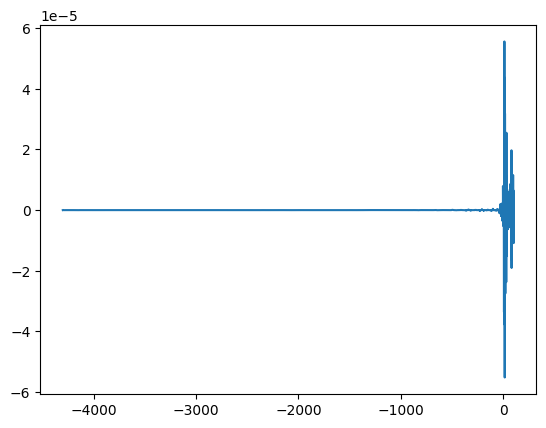

In [17]:
t, h_full, dyn = sur(q, chi1, chi2, dt=1, f_low=0, inclination=incl, phi_ref=phiref, units='dimensionless', precessing_opts={'return_dynamics': True})

#plt.plot(model.data.t_coorb, inertial_h)
#plt.plot(t, h_full)

plt.plot(model.data.t_coorb, interp1d(t, h_full, bounds_error=False, fill_value=0, kind='cubic')(model.data.t_coorb) - inertial_h)

In [10]:
idx

20